## Portfolio Project: Working with a Generative Adversarial Network
Most of the code for this project was provided. The CIFAR10 dataset is loaded, a random class is chosen, and a GAN is trained on images from that class

### Step 1: Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tqdm.notebook import tqdm

### Step 2: Load the Data

Class num 7


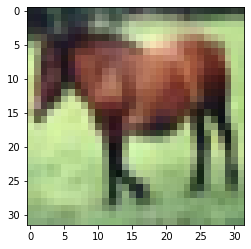

In [2]:
# Load CIFAR10
(X, y), (_,_) = keras.datasets.cifar10.load_data()

# Class number randomly chosen between 1 and 10
class_num = np.random.randint(low=0,high=10,size=1)[0]
X=X[y.flatten() == class_num]

print("Class num {}".format(class_num))
plt.imshow(X[0])
plt.show()
plt.close()


### Step 3: Define parameters to be used in later processes

In [3]:
image_shape = (32, 32, 3)
latent_dimensions = 100

### Step 4: Define a utility functions to build generator and discriminator

In [4]:
def build_generator():

    model = Sequential()

    # Building the input layer
    model.add(Dense(128 * 8 * 8,activation='relu', input_dim=latent_dimensions))
    model.add(Reshape((8,8,128)))

    model.add(UpSampling2D())

    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.78))
    model.add(Activation("relu"))

    model.add(UpSampling2D())

    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.78))
    model.add(Activation('relu'))

    model.add(Conv2D(3, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    # Generating the output image
    noise = Input(shape=(latent_dimensions,))
    image = model(noise)

    return Model(noise, image)

In [5]:
def build_discriminator():
    
    model = Sequential()

    # Convolution layers to process images and classify whether image is real or fake
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))

    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.82))
    model.add(LeakyReLU(alpha=0.25))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.82))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.25))
    model.add(Dropout(0.25))

    #Building the output layer
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    image = Input(shape=image_shape)
    validity = model(image)

    return Model(image, validity)

### Step 5: Utility Function to Display Generated Images

In [6]:
def display_images(generator):
    r, c = 4,4

    noise = np.random.normal(0, 1, (r * c,latent_dimensions))
    generated_images = generator.predict(noise)

    #scaling the generated images
    generated_images = 0.5 * generated_images + 0.5
    fig, axs = plt.subplots(r, c)
    count = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(generated_images[count, :,:,])
            axs[i,j].axis('off')
            count += 1
    plt.show()
    plt.close()

### Step 6: Building the GAN

In [7]:
# Building and compiling the discriminator
discriminator = build_discriminator()
discriminator.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Make the discriminator untrainable so the generator can learn from fixed gradient
discriminator.trainable = False

# Building the generator
generator = build_generator()

# Define generator input
z = Input(shape=latent_dimensions)
image = generator(z)

# Check validity of generated image
valid = discriminator(image)

# Define combined model of generator and discriminator
combined_network = Model(z, valid)
combined_network.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5))

2022-03-29 19:10:57.247455: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Step 7: Train the Network

  0%|          | 0/15000 [00:00<?, ?it/s]

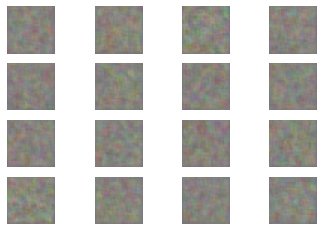

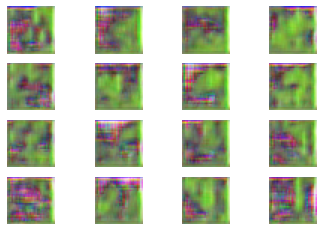

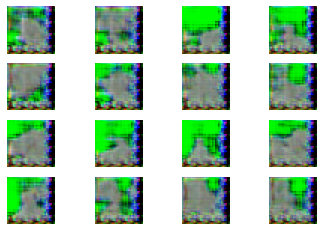

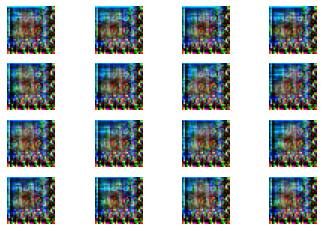

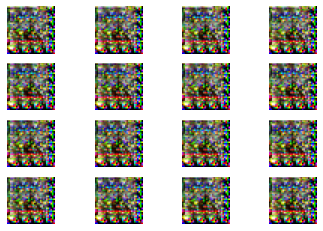

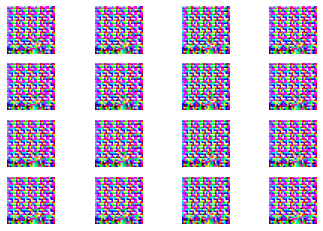

In [8]:
num_epochs=15000
batch_size=32
display_interval=2500
losses=[]

# Normalizing the input
X = (X / 127.5) - 1

# Defining the Adversarial ground truths
valid = np.ones((batch_size, 1))

# Adding some noise
valid += 0.05 * np.random.random(valid.shape)
fake = np.zeros((batch_size, 1))
fake += 0.05 * np.random.random(fake.shape)

for epoch in tqdm(range(num_epochs)):

    # Sampling a random half of images
    index = np.random.randint(0, X.shape[0], batch_size)
    images = X[index]

    # Sampling noise and generating a batch of new images
    noise = np.random.normal(0, 1, (batch_size, latent_dimensions))
    generated_images = generator.predict(noise)

    #Training the discriminator to detect more accurately

    #whether a generated image is real or fake
    discm_loss_real = discriminator.train_on_batch(images, valid)
    discm_loss_fake = discriminator.train_on_batch(generated_images, fake)
    discm_loss = 0.5 * np.add(discm_loss_real, discm_loss_fake)

    #Training the generator

    # Training the generator to generate images that pass the authenticity test
    genr_loss = combined_network.train_on_batch(noise, valid)
    #Tracking the progress               
    if epoch % display_interval == 0:
            display_images(generator)